# Linkin Nodes

In [16]:
import sys
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from urllib.parse import unquote
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

%load_ext autoreload
%autoreload 2
from data.ArticlesParser import process_articles_directory
from data.Graph import *
from data.Preprocessing import *
from data.Path_preprocessing import *
from utils.Visualization import *
from sentence_transformers import SentenceTransformer, util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Preprocessing

In [3]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'data'))
articles_path = os.path.join(data_path, 'plaintext_articles')

# change_name_files_plaintext_articles(data_path)

parsed_articles = process_articles_directory(articles_path)
df = pd.DataFrame(parsed_articles, columns=['Article_Title', 'Related_Subjects', 'Description'])
print(f"There are : {len(df)} articles")
df.head()

There are : 4598 articles


,Article_Title,Related_Subjects,Description
0,Áedán_mac_Gabráin,[British History 1500 and before (including Ro...,"Áedán mac Gabráin was king of Dál Riata, a kin..."
1,Åland,"[Countries, European Countries]","Åland (pronounced IPA: ['oːland] in Swedish), ..."
2,Édouard_Manet,[Artists],"Édouard Manet ( January 23, 1832 – April 30, 1..."
3,Éire,"[Countries, European Countries]",Éire ( pronounced [ˈeːrʲə]) is the Irish name ...
4,Óengus_I_of_the_Picts,[British History 1500 and before (including Ro...,"Óengus, son of Fergus ( Hypothetical Pictish f..."


In [4]:
df_links = preprocessing_links(data_path)
df_links.head()

,Articles,Links
0,10th_century,"[11th_century, 9th_century, Algeria, Beer, Bla..."
1,11th_century,"[10th_century, 12th_century, 13th_century, 14t..."
2,12th_century,"[10th_century, 11th_century, 13th_century, 14t..."
3,13th_century,"[12th_century, 14th_century, Angola, Arabic_la..."
4,14th_century,"[13th_century, 15th_century, Abacus, Aztec, Bl..."


## 2. Model choice and embeddings

The SentenceTransformer("all-MiniLM-L6-v2") model is a popular choice for natural language processing tasks that involve embedding sentences into a dense vector space. It strikes an excellent balance between performance and efficiency, making it highly practical for a wide range of applications.

This model is specifically fine-tuned for generating meaningful sentence embeddings, allowing it to capture the semantic essence of sentences effectively. Its compact size ensures that it is not only fast but also resource-efficient, making it particularly well-suited for real-time or large-scale applications where computational efficiency is crucial

Embeddings are a way to represent data (such as words, sentences, or images) as dense vectors in a continuous vector space. These representations are learned such that they capture the essence or meaning of the input data in a way that similar inputs are closer together in this space.

In [5]:
embeddings_path = os.path.join(data_path, 'embeddings.pkl')
if os.path.exists(embeddings_path):
    df = pd.read_pickle(embeddings_path)
    embedded_articles = dict(zip(df['Article_Title'], zip(df['Article_Title_embedding'], df['Description_embedding'] )))

else:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embedded_articles = articles_to_embeddings(parsed_articles, model, embeddings_path)

To test the function "process_articles_directory," we verify that the embeddings of the titles and descriptions of the articles are similar. For this, we use cosine similarity. We printed only the cosine scores below 0.2 and observed that only three articles fall within this range. This verification step was also useful to determine if the description parsing was done correctly.

In [6]:
for title in embedded_articles:
    score = util.dot_score(*embedded_articles[title])
    if score < 0.2:
        print(f"{title} score: {float(score):.4f}")

Lottie_Dod score: 0.1621
Cheers score: 0.1901
Amur score: 0.1967


In [7]:
# Both are science fiction writers. Using only their names, the cosine similarity
# is low. But with more context, their cosine similarity is high. They are indeed
# bi-directionally linked as they had influence in each other's lives.
print("John Campbell and Isaac Asimov comparison")
john_embedding, john_desc_embedding = embedded_articles["John_W._Campbell"]
isaac_embedding, isaac_desc_embedding = embedded_articles["Isaac_Asimov"]
print(f"Cosine similarity between article names: {float(util.dot_score(john_embedding, isaac_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(john_desc_embedding, isaac_desc_embedding)):.4f}")

# It can also help to disambiguate: a limerick is a form of poetry, so these two
# should be linked if we only take into account the article name. But the Limerick
# article actually talks about the city in Ireland, not the form of poetry.
print("\nLimerick and Poetry comparison")
limerick_embedding, limerick_desc_embedding = embedded_articles["Limerick"]
poetry_embedding, poetry_desc_embedding = embedded_articles["Poetry"]
print(f"Cosine similarity between article names: {float(util.dot_score(limerick_embedding, poetry_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(limerick_desc_embedding, poetry_desc_embedding)):.4f}")

# In the case where the articles should be linked but the description isn't similar
# like winter and summer which are opposing, the description cosine similarity is
# lower, but closer to the article name similarity than in the case of disambiguation.
print("\nWinter and Summer comparison")
winter_embedding, winter_desc_embedding = embedded_articles["Winter"]
summer_embedding, summer_desc_embedding = embedded_articles["Summer"]
print(f"Cosine similarity between article names: {float(util.dot_score(winter_embedding, summer_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(winter_desc_embedding, summer_desc_embedding)):.4f}")

John Campbell and Isaac Asimov comparison
Cosine similarity between article names: 0.2334
Cosine similarity between descriptions: 0.5171

Limerick and Poetry comparison
Cosine similarity between article names: 0.5433
Cosine similarity between descriptions: 0.1685

Winter and Summer comparison
Cosine similarity between article names: 0.6008
Cosine similarity between descriptions: 0.4943


Discussion:
Intuitively, articles should be linked if the cosine similarity between descriptions and titles is higher than a certain threshold. Furthermore, article descriptions allow the model to understand the context better whereas titles sometimes don't offer enough of the latter. This sometimes creates a large difference between cosine similarity scores when comparing descriptions and titles for the same articles. We can therefore leverage article descriptions to disambiguate title names. To learn more about the consine similarity, see section 4.

## 3. Graph

We created a graph with nodes representing articles, embedded titles, and embedded descriptions. The edges represent the links between the articles, and we added attributes such as the cosine similarity between the titles and the cosine similarity between the descriptions.

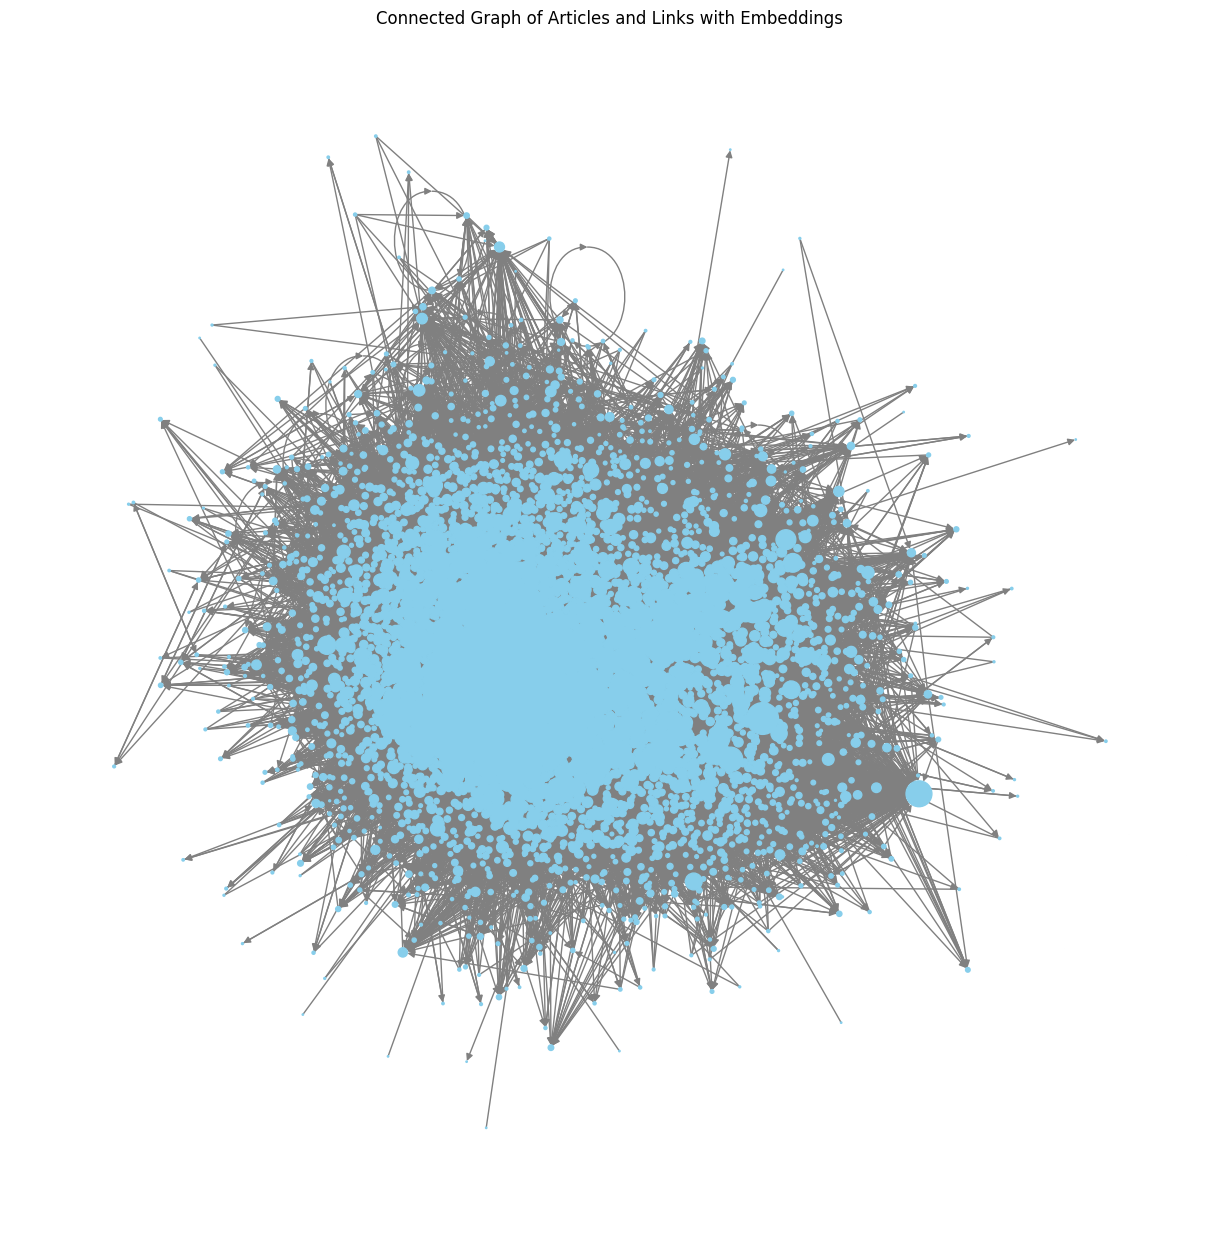

In [8]:
# Creation of the graph, takes time.
G=create_graph(embedded_articles, df_links)
visualize_graph(G)

In [9]:
unconnected_pairs = create_subset_unconnected_nodes(G)

### Graph categories analysis

Now that we have plotted the graph, we want to examine the categories of the edges. The different plots display the categories of both the source and target nodes for each edge, as well as the edges themselves. It is clear that the first category is Geography.

In [14]:
cwd=os.getcwd()
df_path=r"\data\wikispeedia_paths-and-graph\categories.tsv"
file_path=cwd+df_path

df_categories = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['Article', 'Category'])
# Extract the edges
df_links_ = nx.to_pandas_edgelist(G)
df_links_ = df_links_.rename(columns={'source': 'Source', 'target': 'Target'})

# Extract categories
node_data = dict(G.nodes(data=True))
df_categories = df_categories.rename(columns={'index': 'Article'})

if 'Category' in df_categories.columns:
    df_categories['Cleaned_Category'] = df_categories['Category'].str.replace('^subject\.', '', regex=True)
    df_categories['Category_Level_1'] = df_categories['Cleaned_Category'].apply(lambda x: x.split('.')[0] if pd.notna(x) else None)
    df_categories['Category_Level_2'] = df_categories['Cleaned_Category'].apply(lambda x: x.split('.')[1] if '.' in x else None)
    df_categories['Category_Level_3'] = df_categories['Cleaned_Category'].apply(lambda x: x.split('.')[2] if x.count('.') > 1 else None)

Visualization_categories_distribution_premodel(df_links_, df_categories)

In [17]:
countries_map = pd.read_csv("./data/countries_map.csv", delimiter=";", encoding="latin1",header=1)
create_csv_for_map(G,df_categories,countries_map)

### Graph statistical analysis 

To gain a better understanding of the data, some basics but important characteristics of the graph are computed/displayed. This will help guide us in selecting the most appropriate approach for the next steps.

In [9]:
#Make sure to have a connected graph without isolated nodes

#Here we create subgraphs for each connected component
components = list(nx.connected_components(G.to_undirected()))
print(f"Number of connected components: {len(components)}")
subgraphs = [G.to_undirected().subgraph(component).copy() for component in components]

for i in range(len(subgraphs)):
    subgraph_1 = subgraphs[i]
    print(f"Number of nodes in subgraph {i}: {subgraph_1.number_of_nodes()}")
    print(f"Number of edges in subgraph {i}: {subgraph_1.number_of_edges()}")


Number of connected components: 10
Number of nodes in subgraph 0: 4589
Number of edges in subgraph 0: 106644
Number of nodes in subgraph 1: 1
Number of edges in subgraph 1: 0
Number of nodes in subgraph 2: 1
Number of edges in subgraph 2: 0
Number of nodes in subgraph 3: 1
Number of edges in subgraph 3: 0
Number of nodes in subgraph 4: 1
Number of edges in subgraph 4: 0
Number of nodes in subgraph 5: 1
Number of edges in subgraph 5: 0
Number of nodes in subgraph 6: 1
Number of edges in subgraph 6: 0
Number of nodes in subgraph 7: 1
Number of edges in subgraph 7: 0
Number of nodes in subgraph 8: 1
Number of edges in subgraph 8: 0
Number of nodes in subgraph 9: 1
Number of edges in subgraph 9: 0


Except subgraphs[0], the rest correpond to isolated node, so we can get rid of them in the rest of the analysis

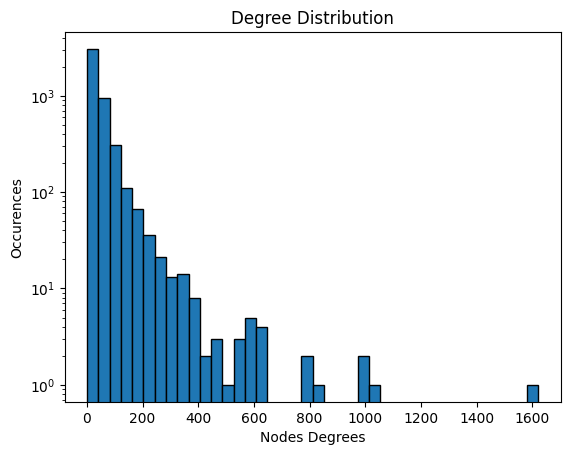

Number of nodes: 4589
Number of edges: 106644
Average degree: 46.48
Network density: 0.0101
Clustering coefficient: 0.2745
Average Shortest path: 2.5253


In [10]:
#subgraphs[0] is fully connected
analyze_graph_statistics(subgraphs[0])

### Results analysis

The graph is medium size and seems well connected, as the number of edges (>100000) is important compared to the number of nodes (~4500), and the average degree is pretty high (46.48).
The distribution of the nodes degrees is a right skewed distribution.
Thought the density is pretty low and indicates potential for discovering new links.
The clustering coefficient indicates that we are more likely to find local clusters.
Finally, it seems that most nodes can be reached from every other node in a small number of steps, as the avergae shortest path is ~2.53.

Thus, the features engineering focus should be on local structure features and short path, but the high connectivity suggests that global features could be important aswell.

## 4. Feature engineering

To train the model, we introduce a set of handcrafted features tailored to the context of link prediction. These features are selected based on the project's aim and the statistical analysis conducted above. They are intended to be the most relevant for achieving effective link creation.
Some of the methods are discussed in the paper "The Link Prediction Problem for Social Networks", by Nowell et al. https://www.cs.cornell.edu/home/kleinber/link-pred.pdf

### Nodes features

**PageRank algorithm** 

This algorithm ranks nodes based on their importance in the network, determined by the structure of incoming links. The basic idea is that a node with a higher PageRank is more influential because it receives more incoming connections from other important nodes.

In [11]:
pr = nx.pagerank(subgraphs[0], alpha=0.9)
df_pagerank = pd.DataFrame(list(pr.items()), columns=['Article', 'PageRank_Score'])
df_pagerank

,Article,PageRank_Score
0,Second_Crusade,0.000135
1,Navassa_Island,0.000263
2,Evan_Rachel_Wood,0.000051
3,Tropical_Storm_Henri_(2003),0.000072
4,Final_Fantasy_Adventure,0.000045
...,...,...
4584,Réunion,0.000224
4585,Flower,0.000505
4586,Banknote,0.000141
4587,Weyto_language,0.000037


**Eigenvector centrality** 

This is a measure of a node's influence within a network, where connections to highly influential nodes contribute more to a node's score than connections to less influential ones. 

In [12]:
#Calculate Eigen centrality for all node pairs
#There are others ways to compute the centrality btw
centrality = nx.eigenvector_centrality(subgraphs[0])
data = []
for u, v in centrality.items():
    data.append({"Article_1": u, "eigenvector": v})
    
#Get the values in a dataframe
df_eigen = pd.DataFrame(data)
df_eigen.sort_values("eigenvector", ascending=False, inplace=True)

df_eigen

,Article_1,eigenvector
3417,United_States,0.179635
4399,France,0.142220
720,United_Kingdom,0.137784
447,Europe,0.132176
3804,Germany,0.120921
...,...,...
2190,Ohm,0.000016
2038,Scheme_programming_language,0.000015
2323,Duchenne_muscular_dystrophy,0.000014
3754,Klinefelter's_syndrome,0.000014


**Common neighbors**

Now, we compare the number of common neighbors between two nodes x and y. Two nodes with a higher number of common neighbors have a higher probability to be linked in the future. 

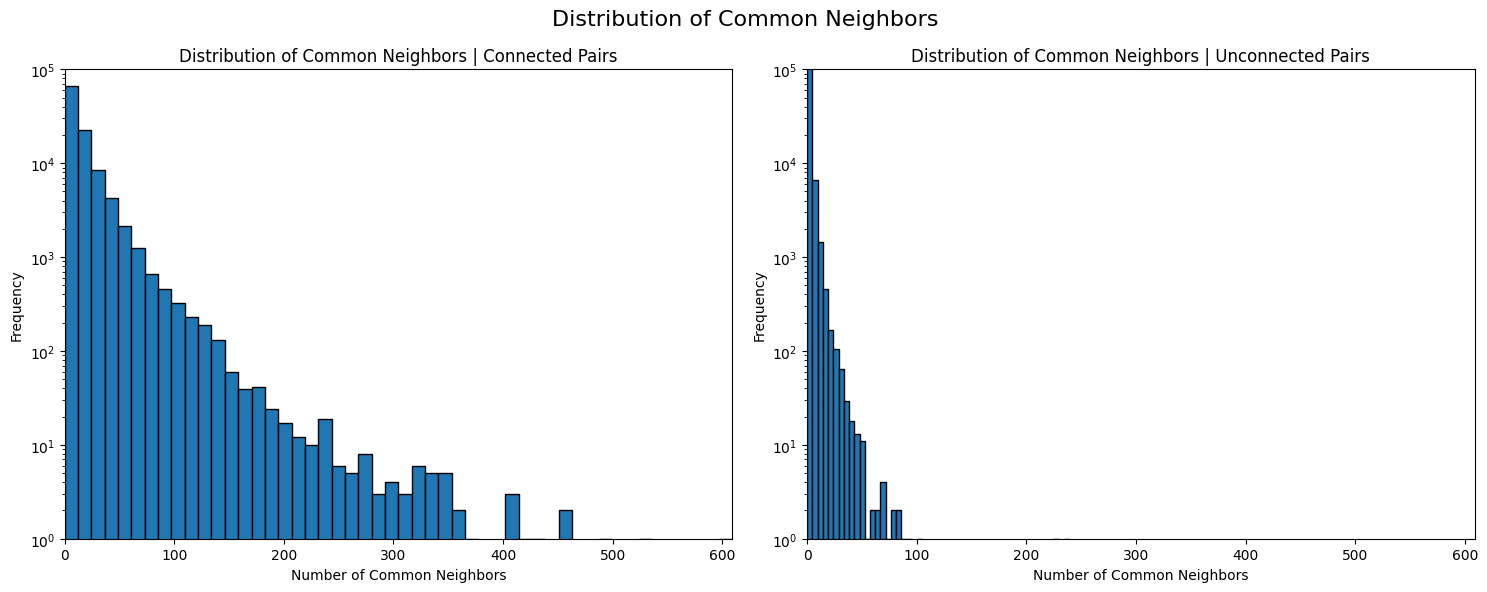

In [13]:
calculate_common_neighbors(G, unconnected_pairs)

Discussion: As expected, connected nodes have a higher number of common neighbors, whereas unconnected nodes have a smaller number of common neighbors. 

**Cosine similarity between Text Embeddings**

Cosine similarity is a measure of the resemblance between two vectors that represent word or text embeddings. The larger the angle between these vectors, the smaller the resemblance, and the smaller the cosine similarity. 
We compare the cosine similarity distribution for article titles and descriptions between unconnected and connected nodes. To avoid too large computational cost, we use a subset of our unconnected nodes.

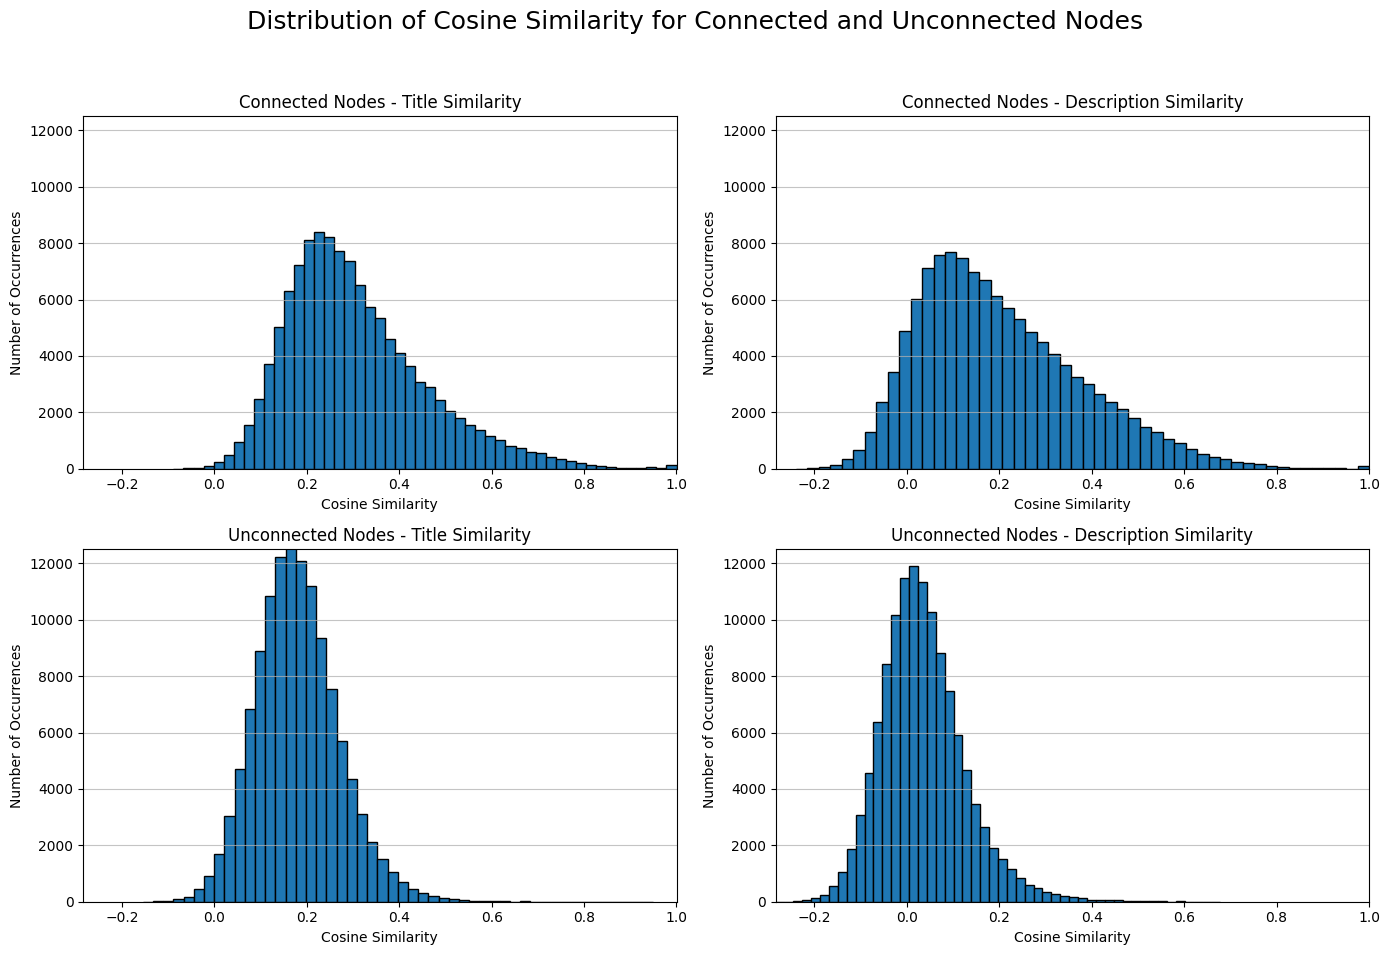

In [14]:
visualize_node_similarity_distributions(unconnected_pairs, G)

Discussion: As expected, the mean values of the unconnected node pairs are smaller than the ones for connected pairs. The latter also have a higher distribution range, representing varying degrees of similarity, whereas the unconnected pairs don't have high range of values, since they are generally less resemblant. The connected pairs have a right skewed distribution indicating larger semantic resemblance. 

Here are some examples of pairs of nodes that should be connected and aren't. They have high cosine similiarity in both title and description cosines, indicating a possible future connection.

In [15]:
similarities = create_node_similarity_distributions(G, unconnected_pairs)

In [16]:
for s in similarities['unconnected_pairs']:
    if s['title_similarity'] > 0.7 and s['description_similarity'] > 0.6:
        print(s['source'] + ' ' + s['target'])

Henry_VI_of_England Henry_I_of_England
Tropical_Storm_Chris_(2006) Tropical_Storm_Lee_(2005)
Plateosaurus Alamosaurus


Below we compare the cosine similarity between titles and descriptions of connected and unconnected node pairs. As expected, unconnected cases have smaller values.

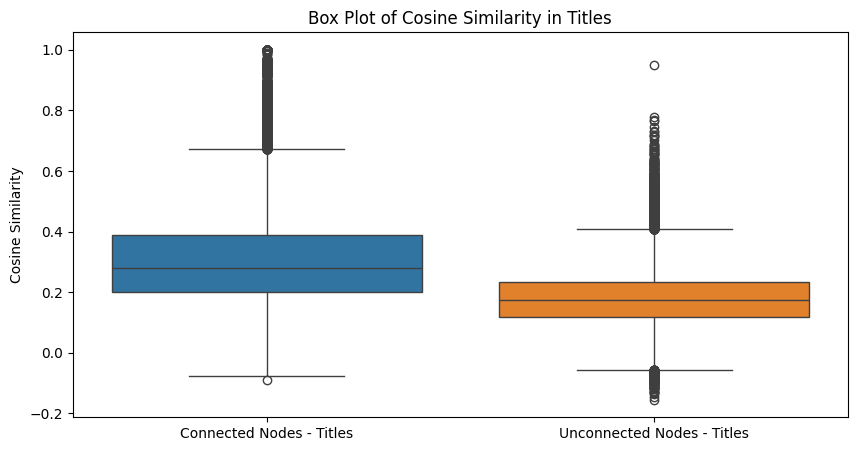

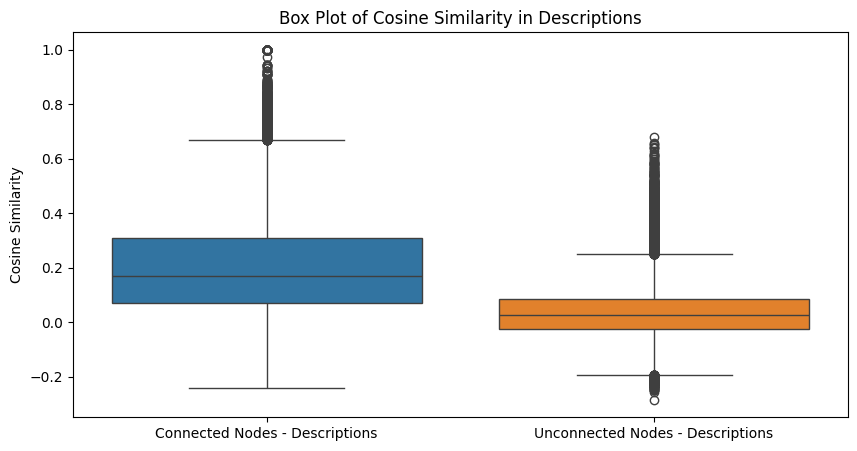

In [17]:
visualize_connected_vs_unconnected_cs_distribution(similarities)

The probability of being connected according to the cosine similarity distributions can be calculated and represented here below. For a given cosine similarity score between two nodes, this graph shows the probabilty of the two nodes being connected according to the cosine similarity distributions of connected and unconnected nodes.

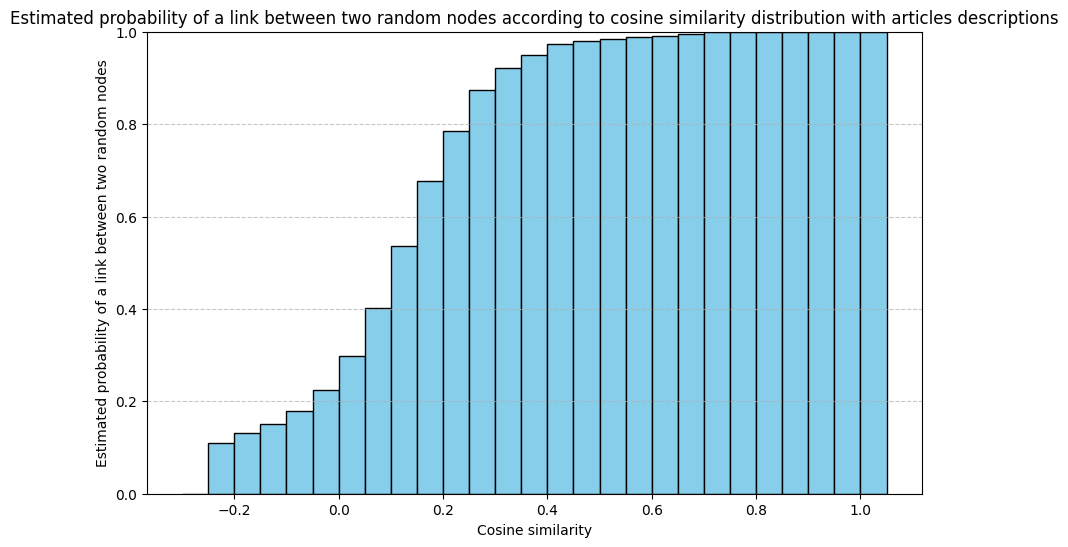

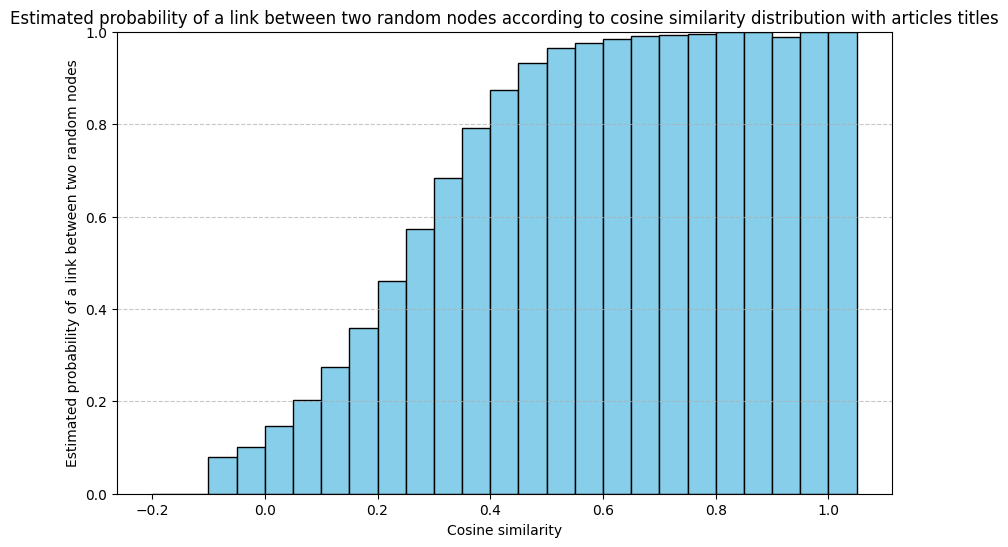

In [18]:
calculate_links_conditional_proba(similarities)

These two probability distributions provide a general sense of the connection between two nodes based on the cosine similarity of their article title and description embeddings. They will later be used for candidate links and zero label non-links selection.

#### Edge features

**Preferential attachment**

Preferential attachment is the principle that a node with more connections is more likely to acquire additional links. This approach assumes that the likelihood of a new connection involving a node x is directly proportional to the number of its existing neighbors. Additionally, the likelihood of two nodes, x and y, forming a co-authorship connection is related to the product of their respective collaborator counts.

Discussion: The preferential attachment scores for the connected pairs can have very large values because we have a very connected and sparse graph. However, some nodes have a very high degree, resulting in large values (x_value range). In contrast, the preferential attachment scores for unconnected pairs are significantly smaller. This is due to the fact that these unconnected nodes, lacking a direct link, generally have less common neighbors, reducing the likelihood of a connection (under the preferential attachment mechanism). 
This difference highlights the impact of common neighbors on connection probability and underscores the structural differences between connected and unconnected pairs in the network.

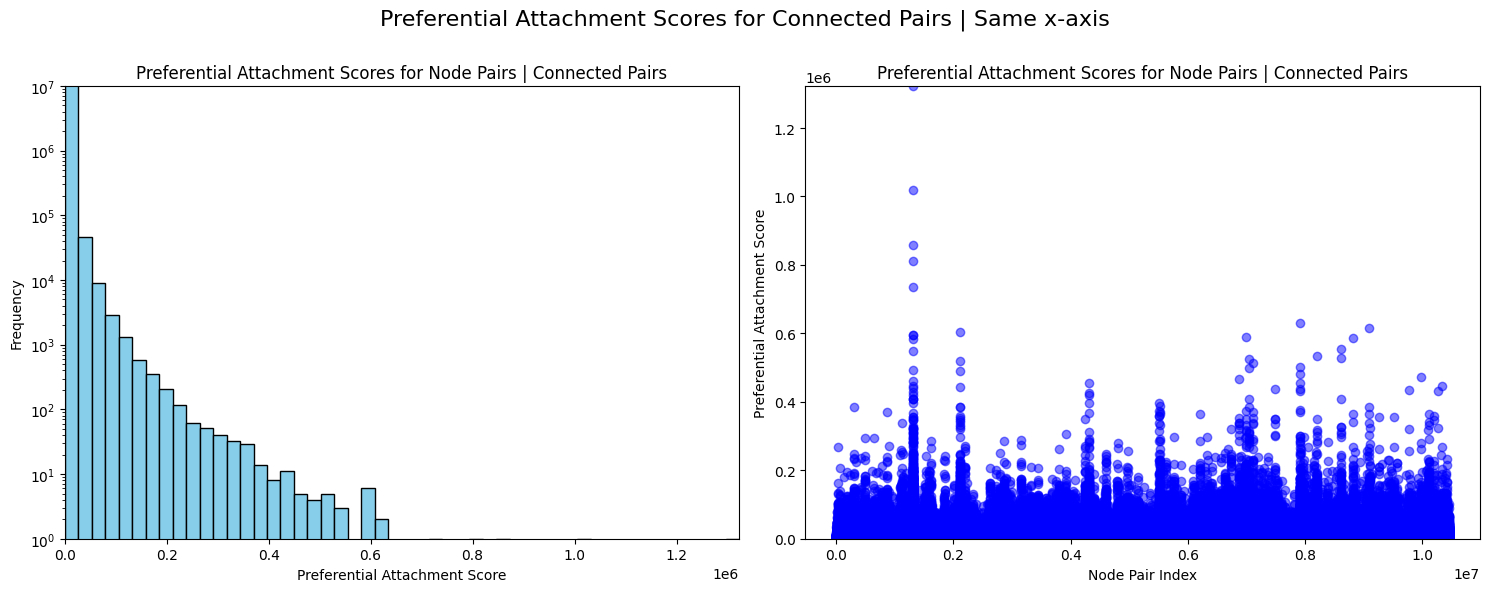

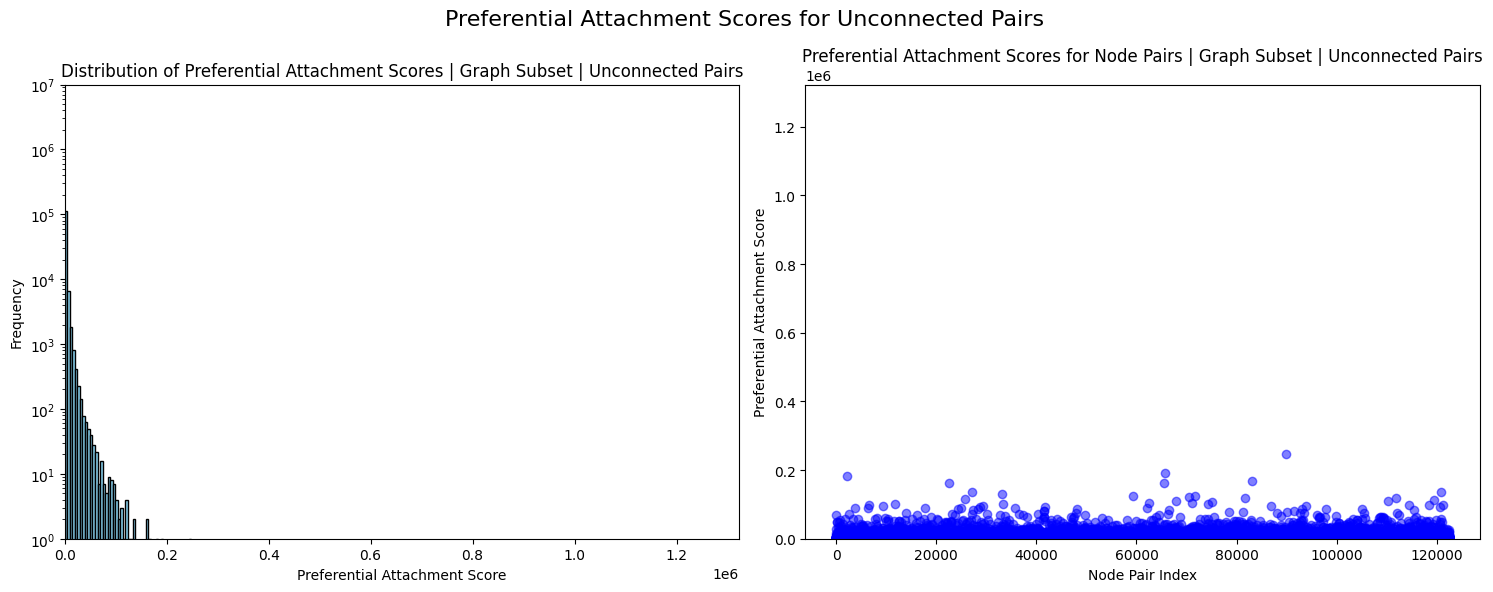

In [19]:
PA_scores = calculate_preferential_attachment(G, unconnected_pairs)

In the plots below and above, we illustrate the preferential attachment scores for connected and unconnected node pairs of our network. The unconnected nodes plots are replotted below to show the graph, since their values are minuscule compared to the connected pairs. 


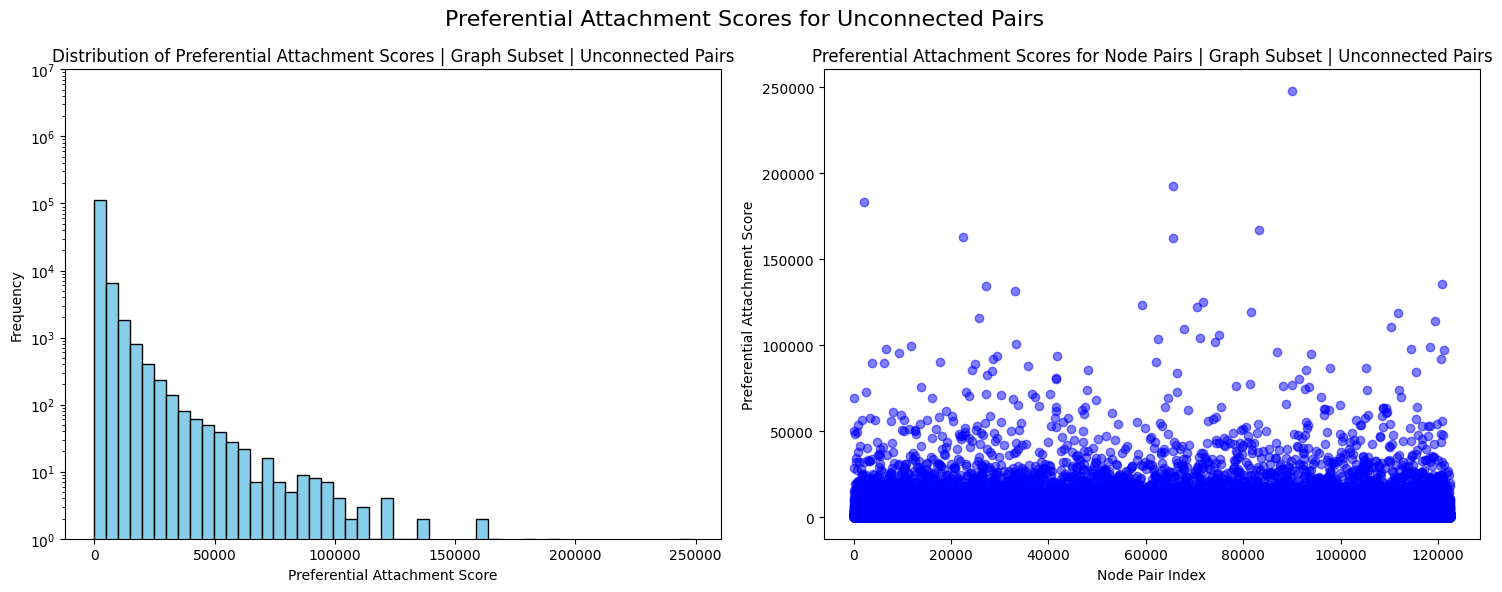

In [20]:
calculate_preferential_attachment_unconnected_zoomed(G, unconnected_pairs)

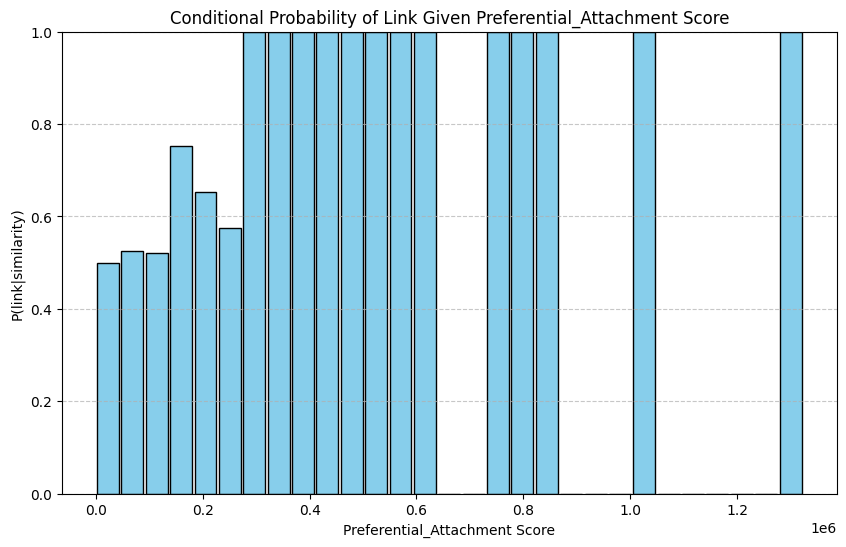

In [21]:
df_PA, fig_PA = calculate_conditional_probability(PA_scores, "Preferential_Attachment")
plt.show()

Due to the lack of smoothness in the conditional probability distributions of connected and unconnected nodes based on their Preferential Attachment scores (as observed above), we have decided against using this metric to select candidates and negative examples (0 label non-links).

**Jaccard similiraty**

The Jaccard's coefficient is a commonly used similarity metric in information retrieval. It measures the probability that both x and y have a feature f, knowing that x or y has the feature f (which is randomly selected). In our case, the features are the neighbors. It is defined as the size of the intersection divided by the size of the union of the sets.

Discussion: Below we compare the Jaccard's coefficients for both connected and unconnected node pairs. As expected, the Jaccard coefficient values are higher for connected node pairs, as the likelihood of sharing a neighbor increases when nodes are directly connected.

In [22]:
#Calculate Jaccard similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
jaccard_similarities = nx.jaccard_coefficient(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in jaccard_similarities:
    data.append({"Article_1": u, "Article_2": v, "jaccard_similarity": p})

df_jaccard = pd.DataFrame(data)
df_jaccard.sort_values("jaccard_similarity", ascending=False, inplace=True)

df_jaccard

,Article_1,Article_2,jaccard_similarity
10225522,Hawfinch,Reed_Bunting,1.0
5742449,Eurasian_Bullfinch,Hawfinch,1.0
5742716,Eurasian_Bullfinch,Reed_Bunting,1.0
5154371,Klinefelter's_syndrome,Duchenne_muscular_dystrophy,1.0
1137394,Emma_Roberts,T._D._Judah,1.0
...,...,...,...
6528110,EMD_F7,MINI_(BMW),0.0
6528109,EMD_F7,Stephen_Hawking,0.0
6528108,EMD_F7,Sean_Connery,0.0
6528107,EMD_F7,Copenhagen,0.0


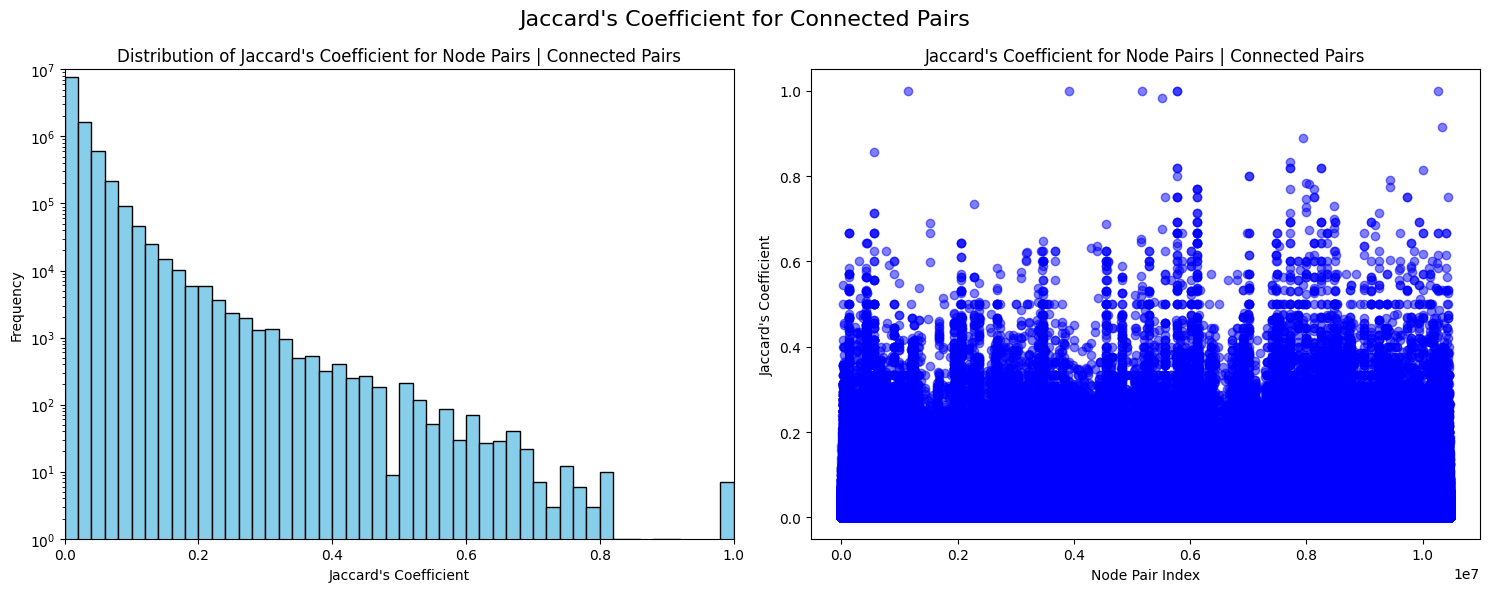

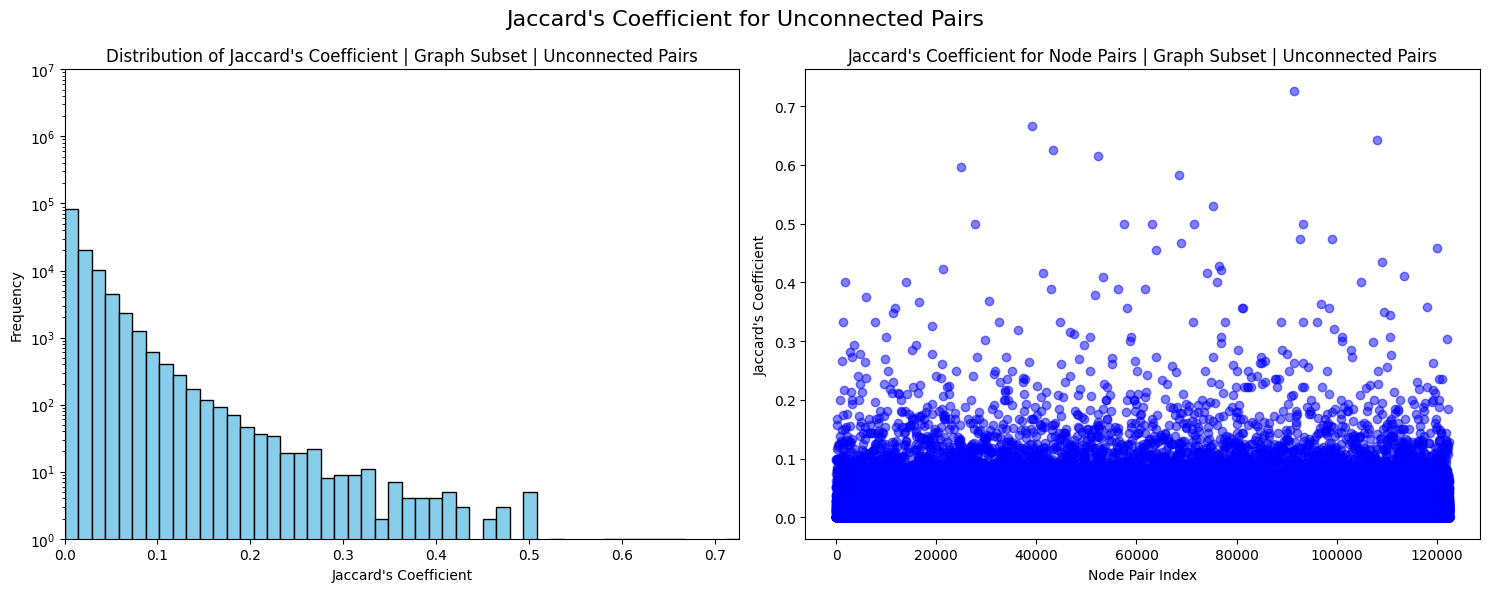

In [23]:
jaccards_scores = calculate_jaccards_coeff(G, unconnected_pairs)

The probability of being connected according to the jaccard scores distributions can be calculated and represented here below. For a given jaccard score between two nodes, this graph shows the probabilty of the two nodes being connected according to the jaccard score distributions of connected and unconnected nodes.

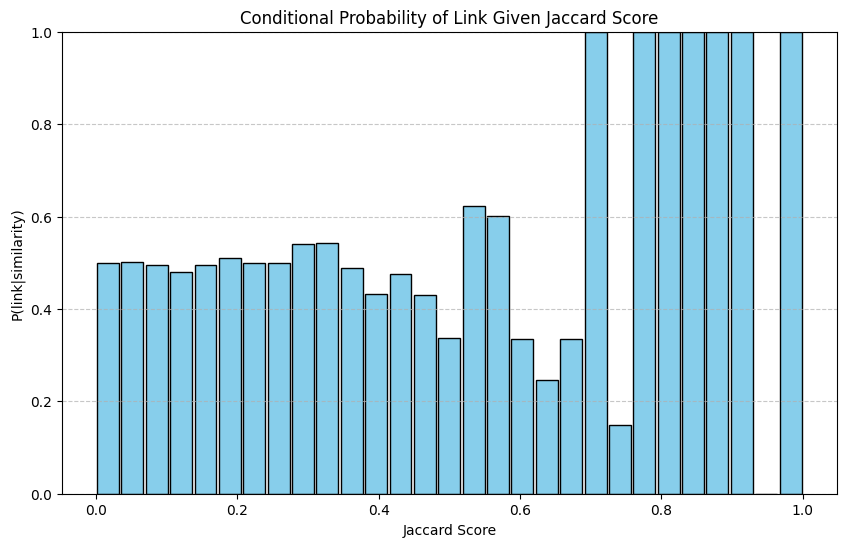

In [24]:
df_j, fig_j = calculate_conditional_probability(jaccards_scores, "Jaccard")
plt.show()

As we can see, the probability there is not much information about the probability of two nodes being connected when the jaccard score is below 0.8. When the Jaccard score gets to 0.8, the probability of a connection shoots up to 100%, meaning we can use this probability distribution, later when selecting the candidate links and 0 label non-links.

**Adamic adar index**

To determine how closely two personal home pages are linked, Adamic and Adar examine their common features. Unlike a simple count of these shared features, this index weighs the contribution of each distinctive or less frequent feature by the inverse logarithm of its degree, assigning more weight to rarer features to measure the similarity between entities.

Discussion: We observed the differences between connected and unconnected pairs of nodes. As expected, the values for connected pairs of nodes are larger than those for unconnected pairs of nodes because there is a greater likelihood of shared connections or features when nodes are directly linked.

In [25]:
# Calculate Adamic_adar_index similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
adamic_adar_index = nx.adamic_adar_index(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in adamic_adar_index:
    data.append({"Article_1": u, "Article_2": v, "adamic_adar_index": p})

df_adamic = pd.DataFrame(data)
df_adamic.sort_values("adamic_adar_index", ascending=False, inplace=True)

df_adamic

,Article_1,Article_2,adamic_adar_index
1306838,United_States,England,83.407958
9219101,Chordate,Binomial_nomenclature,72.607095
1306260,United_States,London,68.688406
8585905,Scientific_classification,Europe,59.432855
7084600,India,China,54.999616
...,...,...,...
6017727,Cultural_diversity,Plate_tectonics,0.000000
6017726,Cultural_diversity,James_Stewart_(actor),0.000000
6017725,Cultural_diversity,Basil,0.000000
6017724,Cultural_diversity,Yellow_fever,0.000000


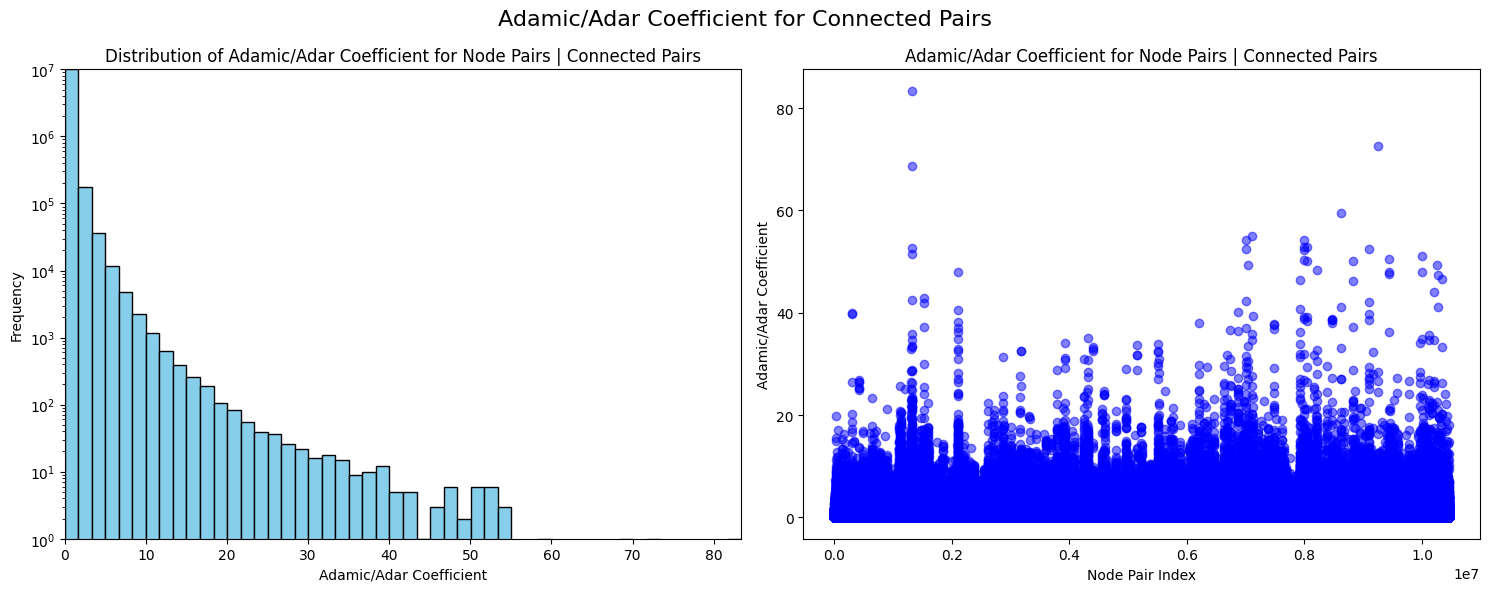

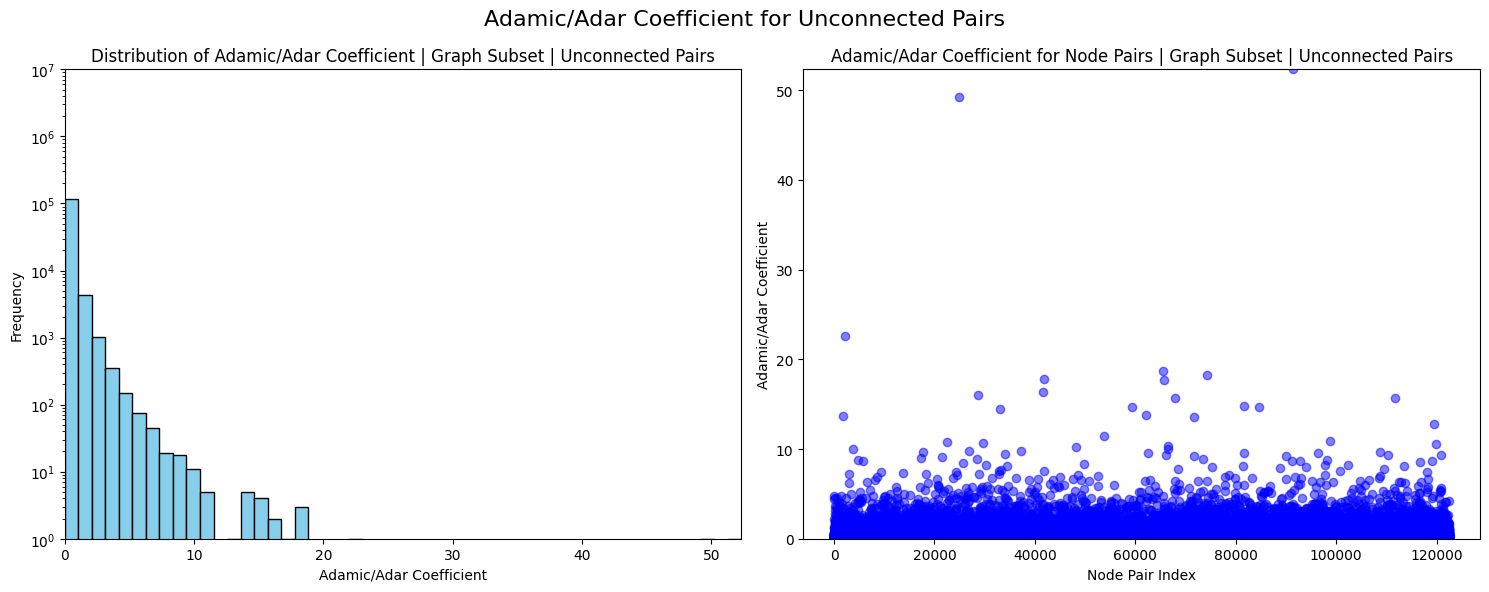

In [26]:
adar_scores = calculate_adamic_adar(G, unconnected_pairs)

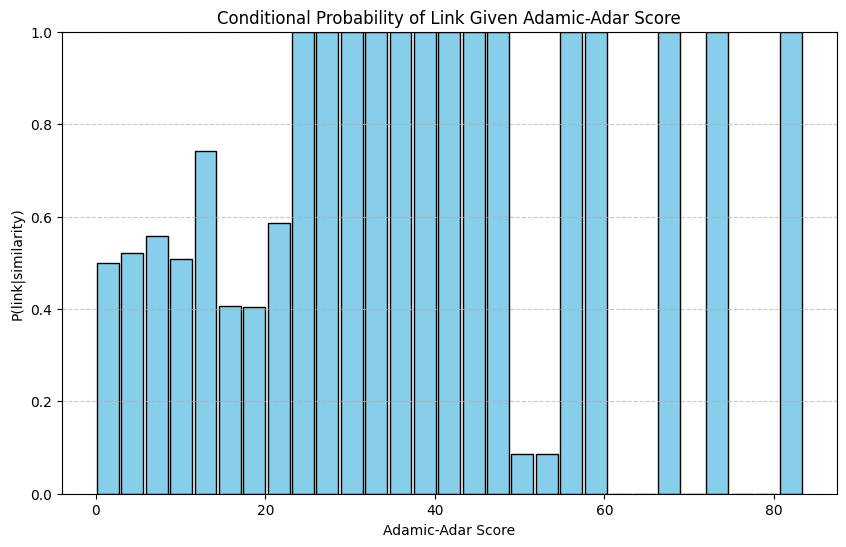

In [27]:
df_aa, fig_aa = calculate_conditional_probability(adar_scores, "Adamic-Adar")
plt.show()

Due to the lack of smoothness in the conditional probability distributions of connected and unconnected nodes based on their Adamic-Adar scores (as observed above), we have decided against using this metric to select candidates and negative examples (0 label non-links).

## 5. Human Data Analysis

This could be an interesting way to use the human data from the "paths_finished" and "paths_unfinished datasets": compare wikispeedia metrics after the update of the graph. We could look for shortcuts created in existing players paths by new links. We could also look for the last page from every unfinished_paths and infer that new links could have helped the player. To get significant statistical results, there is a real need to know the size of these two datasets.

### Finished Paths

Preprocessing of finished paths:
Adding a "Num_Page_Visited" column counting length of the paths
Removing the Dead end Articles "Wikipedia_Text_of_the_GNU_Free_Documentation_License;<" sequence as it alwas lead to a return to previous page.

In [26]:
data_path = os.path.abspath(os.path.join(os.getcwd(), r'data'))
games_path = os.path.join(data_path, r'wikispeedia_paths-and-graph')
finished_file_path = os.path.join(games_path, r'paths_finished.tsv')

df_finished = process_finished(finished_file_path)
print(f"There are : {len(df_finished)} finished paths")
df_finished.head()

There are : 51318 finished paths


,session_id,timestamp,duration,path,rating,num_pages_visited
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,9
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,5
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,8
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,4
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,7


In [27]:
statistics(df_finished)

Mean length of paths: 6.756693557815971
Median path length: 6.0
Mean Game duration: 158.27619938423166 seconds
Median Game duration: 107.0 seconds
Maximum pages visited: 8046
Duration of longest game: 10855 seconds


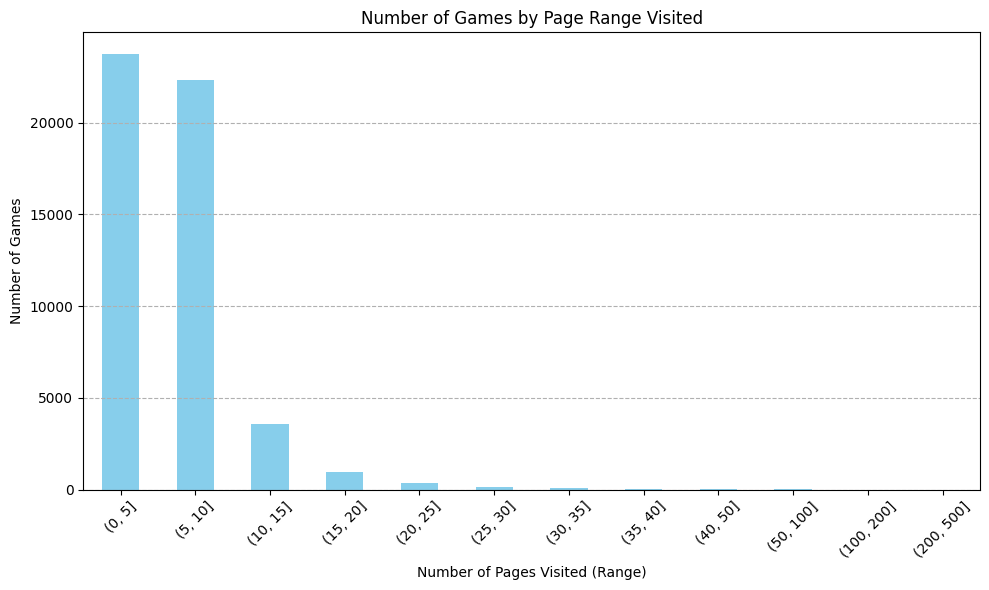

In [28]:
plot_num_pages(df_finished)

Less than 5 articles are visited by almost 50% of the paths. These paths will be less affected by a modification of the graph since there will be fewer chances of a shortcut. The amount of visited articles falling into the class of (5,10] will be useful since there will be enough of them, and there will be enough articles visited to make a difference.

In [29]:
df_visits = most_visited(df_finished)

Page: United_States, Visits: 8896
Page: Europe, Visits: 4362
Page: United_Kingdom, Visits: 3904
Page: England, Visits: 3332
Page: Earth, Visits: 3223
Page: Africa, Visits: 2796
Page: World_War_II, Visits: 2301
Page: North_America, Visits: 1884
Page: Germany, Visits: 1769
Page: Animal, Visits: 1713


Expectedly, United States is the most connected node and at the same time one of the most visited nodes from players. Similarly, the other articles in the top are highly connected nodes representing vast subjects/countries.

Using paths that were played many times would ensure a better statistical signifiance in terms of impact of the graph update.

In [30]:
df_path_counts = number_games(df_finished)

Top 10 most frequent paths:
      start_page           end_page  count
2318    Asteroid             Viking   1043
4427       Brain          Telephone   1040
25700    Theatre              Zebra    905
21255    Pyramid               Bean    642
3206      Batman               Wood    148
3825        Bird  Great_white_shark    138
3201      Batman      The_Holocaust    119
3822        Bird       Adolf_Hitler    107
3498        Beer                Sun     99
3174      Batman             Banana     69


In [31]:
stats_on_games(df_path_counts)

Number of different paths played: 28718
Mean number of time a path is played: 1.7869628804234279
Median number of played path: 1.0
Paths that were played only once: 20060


What we can infer from these information is that an extremely large majority of them are played only once which will decrease the number of paths that could reach statistical significance. We do have two paths played more than a thousand times and lots more played more than 50 times, which would allow us a reasonable number of paths to work with.

### Unfinished Paths

Unfinished Paths preprocessing:

Adding the "Num_Page_visited" column
Remove all the paths ending on the dead end article "Wikipedia_Text_of_the_GNU_Free_Documentation_License"
Separate Games that were played (more than 1 page visited) than those who were not

In [34]:
unfinished_file_path = os.path.join(games_path, r'paths_unfinished.tsv')
df_unfinished, df_untried = process_unfinished(unfinished_file_path)

df_unfinished.head()

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/data/Path_preprocessing.py:149: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_played_unfinished = unfinished_paths_filtered[unfinished_paths['num_pages_visited'] == 1]
/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/data/Path_preprocessing.py:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  played_unfinished = unfinished_paths_filtered[unfinished_paths['num_pages_visited'] > 1]


,session_id,timestamp,duration,path,target,type,num_pages_visited,path_list
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,3,"[Malawi, Democracy, Alexander_the_Great]"
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2,"[Paraguay, Bolivia]"
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,4,"[Agriculture, History_of_the_world, China, Yan..."
6,486bb79910fe9dd2,1297101660,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout,7,"[Mind, Christianity, Europe, Renaissance, Anci..."
7,6d136e371e42474f,1297102070,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart,5,"[4-2-0, United_States, Agriculture, Sugar, Aus..."


In [35]:
stats_unfinished(df_unfinished, df_untried)

There are : 24815 unfinished games
There are : 19601 failed games and 5214 not attempted games
Mean length of paths: 6.315392071833069
Median path length: 5.0
Mean Game duration: 865.7305239528596 seconds
Median Game duration: 292.0 seconds
Maximum pages visited: 4247
Duration of longest game: 4247 seconds


## 6. Candidates and Non-links data selection

To train the GCN model, we first need to determine the data that will be used for training. Since our goal is supervised learning, we can easily gather the positive examples (1 label) by including all the existing links in the graph. The more challenging part is selecting node pairs to serve as negative examples (0 label), ensuring these pairs are definitely not connected, so they can be used for training. Additionally, we must identify pairs of candidate links for inference, where the GCN model will predict whether a link exists.

In [36]:
jaccard_scores = calculate_jaccards_coeff(G, unconnected_pairs, plot=False)

# Create the zero-label non-links from article title and description similarities
zero_label_non_links = create_zero_label_non_links(similarities)
print(f"Number of zero-label non-links: {len(zero_label_non_links)}")

# Use jacard scores to filter out non-links that are too similar.
zero_label_non_links = calculate_labels_jaccard(jaccard_scores, zero_label_non_links)
print(f"Number of zero-label non-links after filtering: {len(zero_label_non_links)}")

candidates = calculate_labels_cos_similarity(G, similarities)

Number of zero-label non-links: 120000
Number of zero-label non-links after filtering: 120000


The process for creating zero-label non-links and candidate pairs involves multiple steps. First, unconnected node pairs with the lowest average cosine similarity (based on title and description weights) are selected as zero-label non-links, limited to a target size (based on the number of 1 label links to get a balanced dataset). These pairs are then filtered using Jaccard scores to remove those with high similarity, ensuring low-likelihood pairs remain.

For candidate pairs, unconnected nodes with average cosine similarity exceeding the mean similarity of connected pairs are identified. This ensures the zero-label non-links represent unlikely connections, while candidate pairs represent potential links for prediction.

In [37]:
print("Length of Final Candidates:", len(candidates))
print("Length of Non-links:", len(zero_label_non_links))

Length of Final Candidates: 5313
Length of Non-links: 120000


## 7. Training the model

A training script is used to train the GCN model, inside train.py. Ablation studies were conducted to respond to the first two research questions, namely:
- Can article names and descriptions embeddings be used to infer a link between two articles?
- What are the most descriptive features/heuristic methods to infer links between two articles?
As features are dropped, we can determine which ones affect the loss curves and the metrics the most.

Processing dropped_jaccard_similarity...
Processing dropped_adamic_adar_index...
Processing dropped_eigenvector_centrality...
Processing dropped_preferential_attachment...
Processing dropped_title_embedding...
Processing dropped_pagerank...
Processing full_model...
Processing dropped_description_embedding...


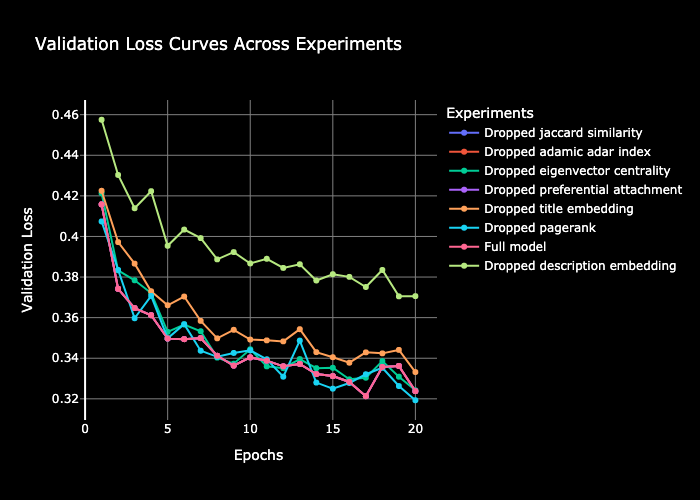

In [38]:
from models.Analyze import *

plot_validation_loss_curves('results', save=False)

The loss curves above clearly illustrate a significant drop in performance when the description embedding is removed, highlighting it as the most informative feature in the graph. Following this, the title embedding proves to be the second most important feature, as its removal also leads to a noticeable decline in performance. Conversely, the edge features—such as Jaccard similarity, Adamic-Adar index, and preferential attachment—show no impact on the loss curves compared to the full model, indicating they have no influence on the model’s decisions. Consequently, these features were excluded. It is worth noting that the lack of informativeness of the edge features had already been observed, and the cosine similarities were also discarded as a feature due to their low descriptiveness. However, they were still utilized for zero-label non-link and candidate selection.

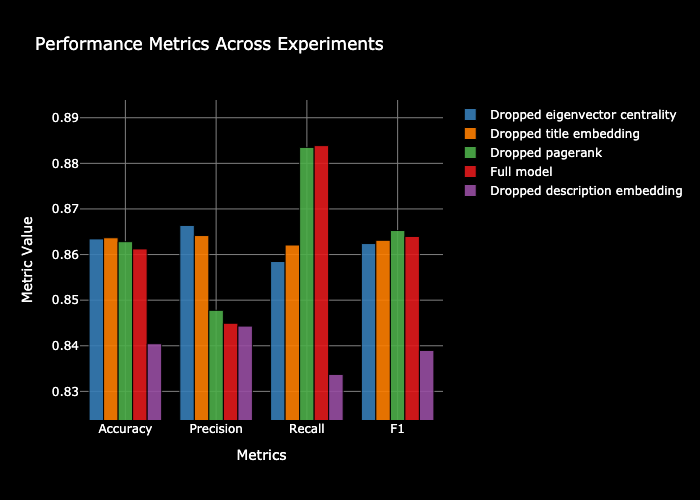

In [39]:
plot_experiment_metrics('results', save=False)

From the metrics that can be seen above, the only real conclusion we can make is that the description embeddings are the most descriptive and dropping them lead toa significant (2 percentage points) drop in performance. The best model in terms of F1 score seems to be the one where the pagerank score was dropped, however the only difference between that model and the full model is 0.12 percentage points, which is not significant.

### Model selection

The full model or the model with PageRank dropped are preferred due to their higher recall. This choice aligns with the task's objective of predicting new links in the Wikipedia graph to improve navigation between articles on the website. With higher recall, we have as many potential links as possible for easier navigation between articles. The cost for false positives is not high, as it doesn't distract users who read the articles. But the cost of false negatives is high, if a user wants to find an article but can't because of missing links.

## 8. Analysis of the model

- In this section we analyse the model's output by looking closely to the general features of the created graph, the distribution of new links and to the accuracy of the model over the categories.

- Load the files and preprocessing

In [9]:
# Load the files

cwd=os.getcwd()
df_path=os.path.join(cwd, "data","wikispeedia_paths-and-graph","categories.tsv")
links_path=os.path.join(cwd, "results","full_model","linked_nodes.csv")
df_links_ = pd.read_csv(links_path,sep=",")
df_links_with_pred=pd.read_csv("linked_nodes_with_predictions_test.csv",sep=",")
df_categories = pd.read_csv(df_path, sep='\t', comment='#', header=None, names=['Article', 'Category'])

# Decode the URL-encoded article names
df_categories['Article'] = df_categories['Article'].apply(unquote)

# Remove the "subject." prefix from the Category column
df_categories['Cleaned_Category'] = df_categories['Category'].str.replace('^subject\.', '', regex=True)

# Split the cleaned categories into hierarchical levels
df_categories['Category_Level_1'] = df_categories['Cleaned_Category'].apply(lambda x: x.split('.')[0] if pd.notna(x) else None)
df_categories['Category_Level_2'] = df_categories['Cleaned_Category'].apply(lambda x: x.split('.')[1] if '.' in x else None)
df_categories['Category_Level_3'] = df_categories['Cleaned_Category'].apply(lambda x: x.split('.')[2] if x.count('.') > 1 else None)

# Drop the original and intermediate columns if not needed
df_categories = df_categories.drop(columns=['Category', 'Cleaned_Category'])

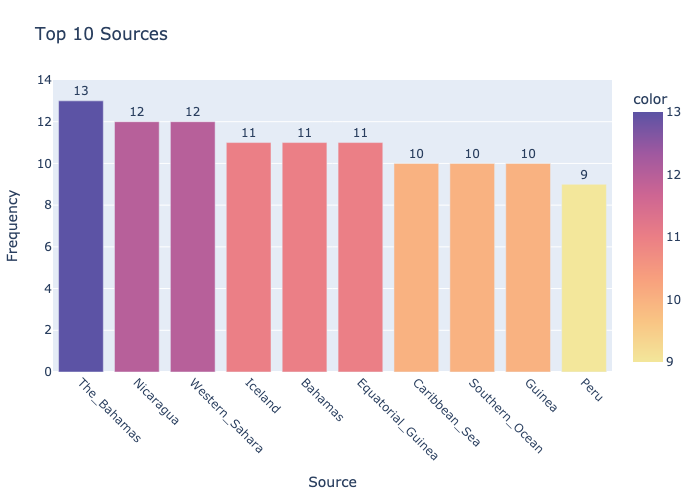

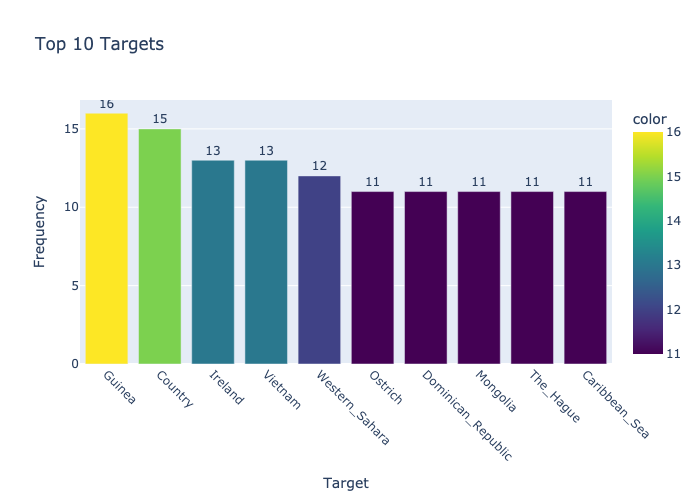

Degree Distribution


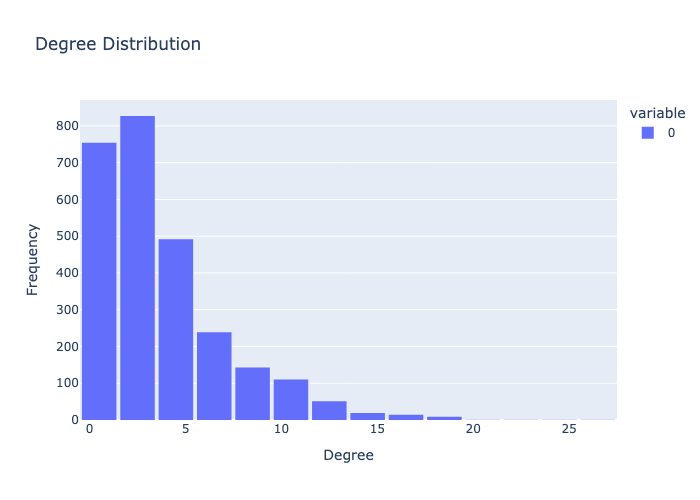

Graph Visualization


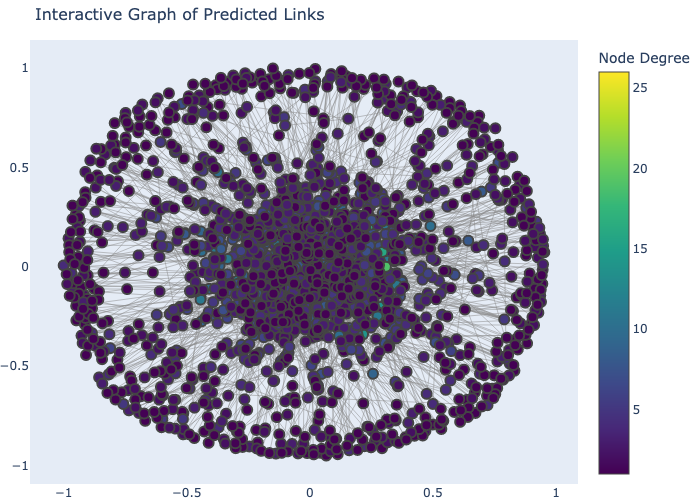

In [48]:
Visualization_post_model(df_links_)

- The sources and targets nodes that show a high degree are all places, suggesting that the Geography/Countries Categories might play an important role.
- By looking at the degree distribution, it appears clear that most of the created links originate from different nodes, as most of the nodes have a degree ranging between 1 to 3. There is no node that allows to link to a lot of pages.

# Distribution over the categories

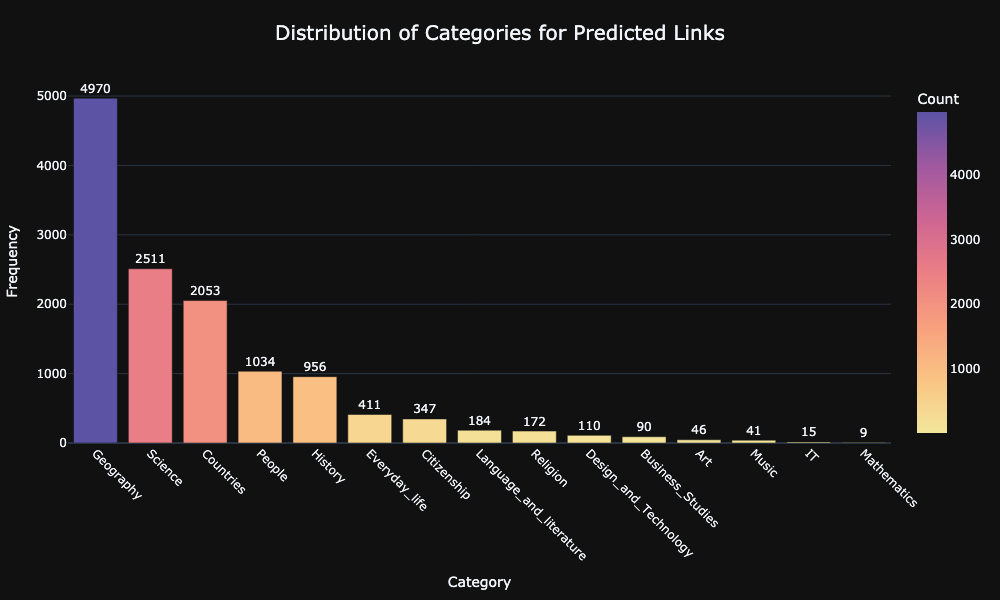

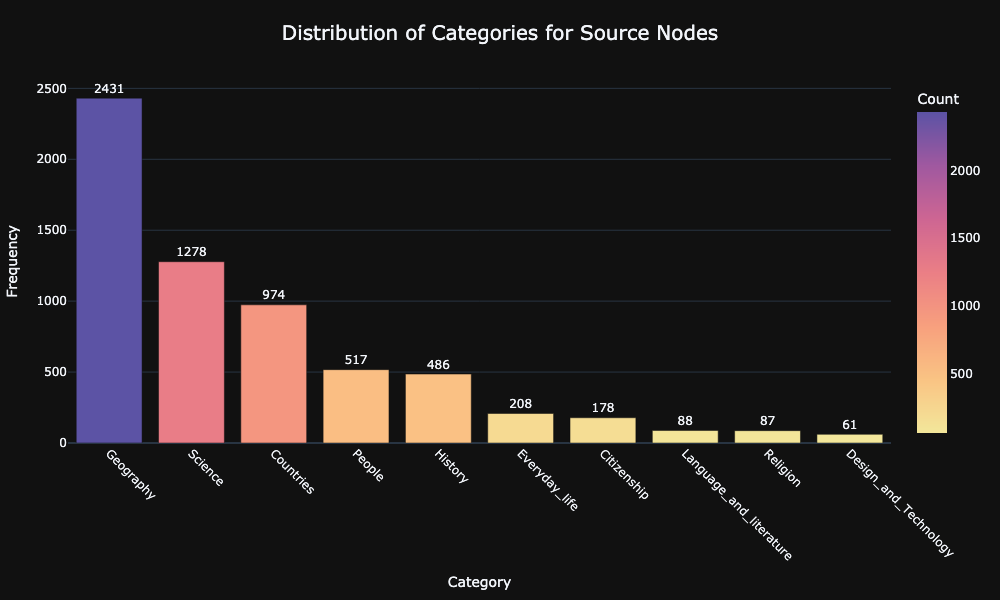

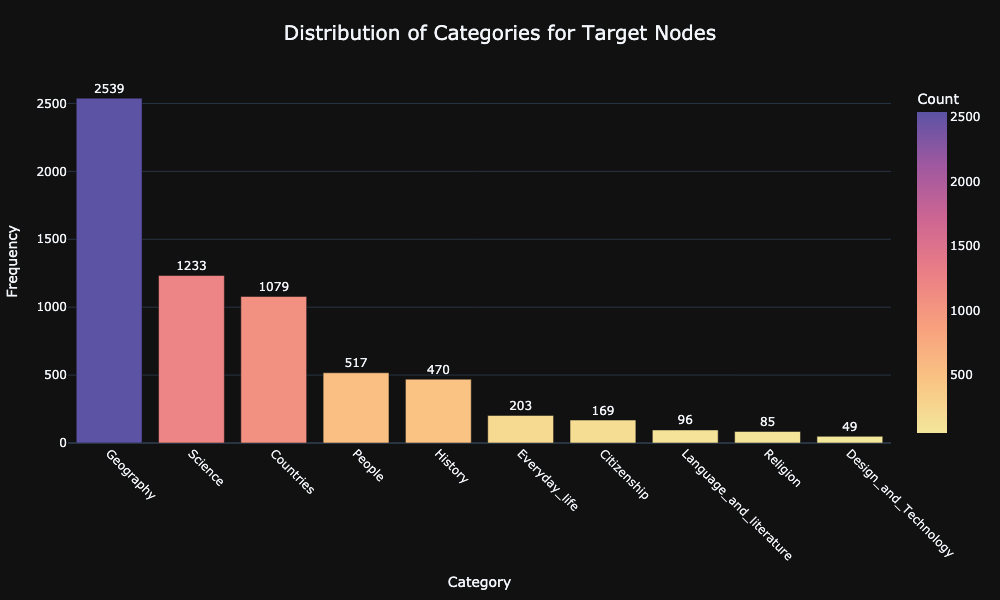

In [51]:
Visualization_categories_distribution(df_links_,df_categories)

- As expected, the Geography category from and to which most links are created. If we compare the distribution of the categories of the wikispeedia dataset and of the graph that the model generated, we observe a very similar result.

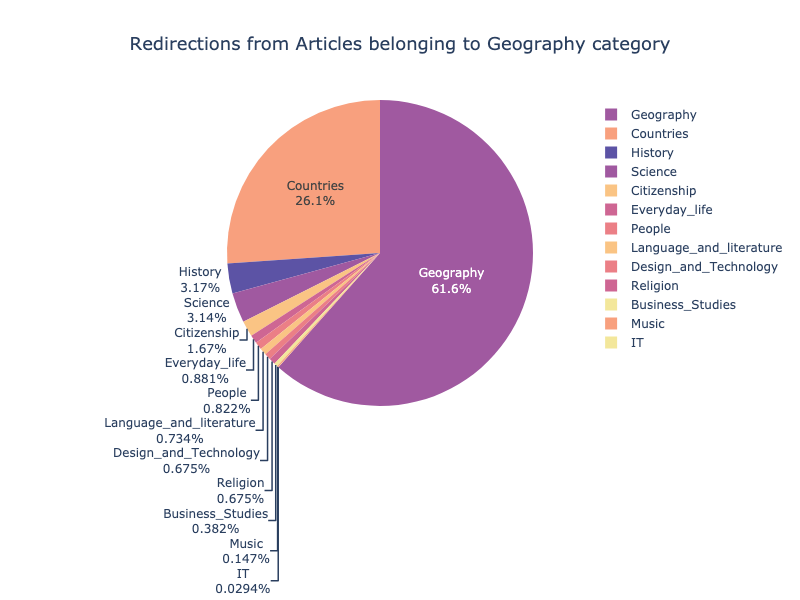

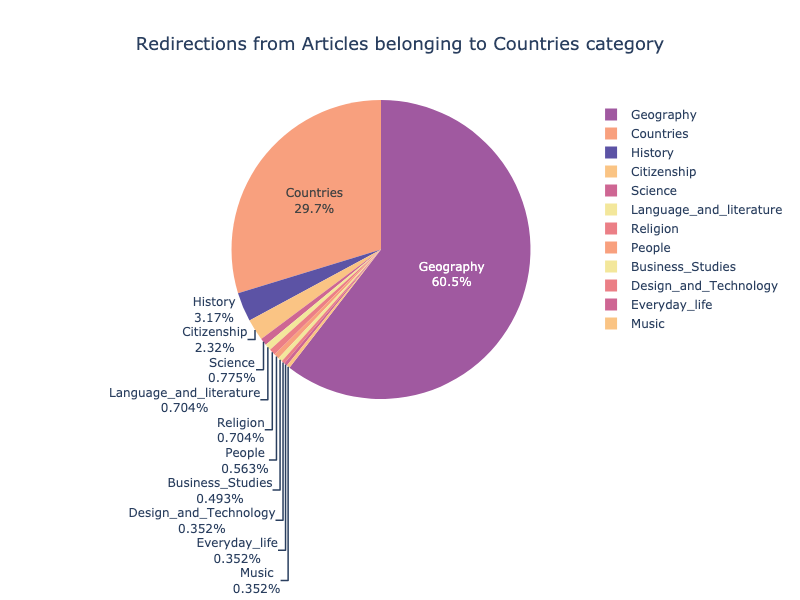

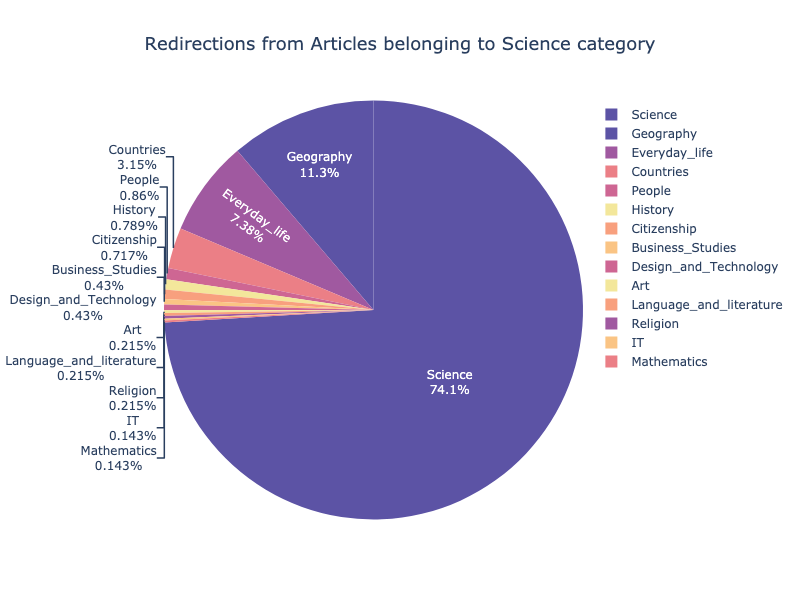

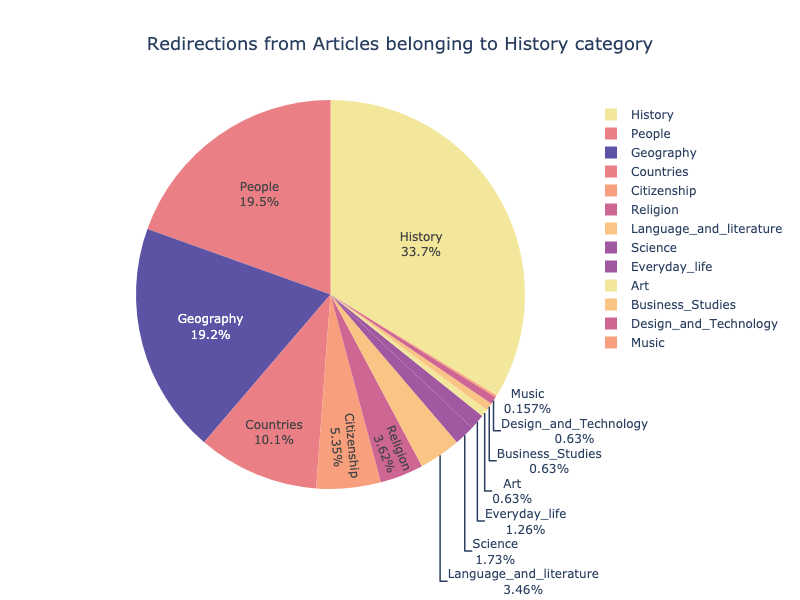

In [52]:
visualization_pie_charts(df_links_,df_categories)

- The nodes belonging to one category tend to link mostly to the same category, apart for the History Category.
- We can also note the strong duo Country-Geography.

# Error for with respect to the most common categories

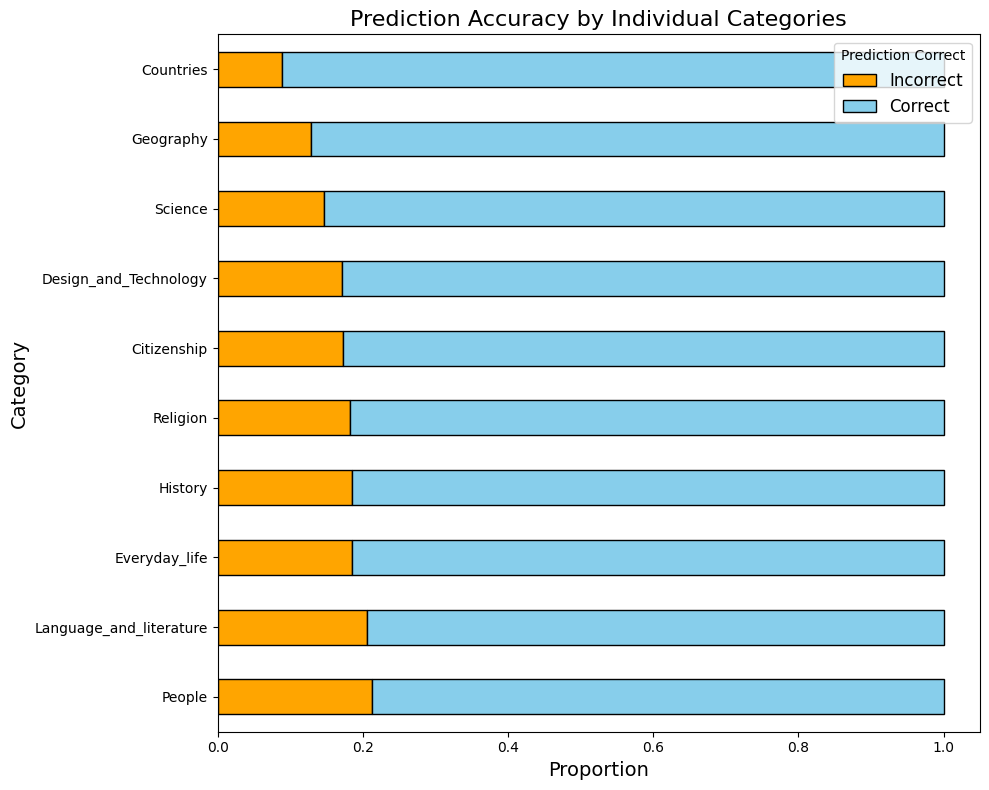

In [24]:
Visualization_error_bars(df_links_,df_categories)

- The Accuracy of the model over the categories is very high, especially for the most represented categories, such as Geography, which explains why the models shows an overall high accuracy.

In [54]:
linked_nodes = pd.read_csv("./results/full_model/linked_nodes.csv")

In [55]:
G_new_edges =add_edges_from_csv(G, linked_nodes)

#Here we create subgraphs for each connected component
components = list(nx.connected_components(G.to_undirected()))
print(f"Number of connected components: {len(components)}")
subgraphs_new_edges = [G.to_undirected().subgraph(component).copy() for component in components]

Number of connected components: 10


Let us compare the new graph's statistics to the original graph statistics, namely:
- Number of nodes: 4589
- Number of edges: 106644
- Average degree: 46.48
- Network density: 0.0101
- Clustering coefficient: 0.2745
- Average Shortest path: 2.5253

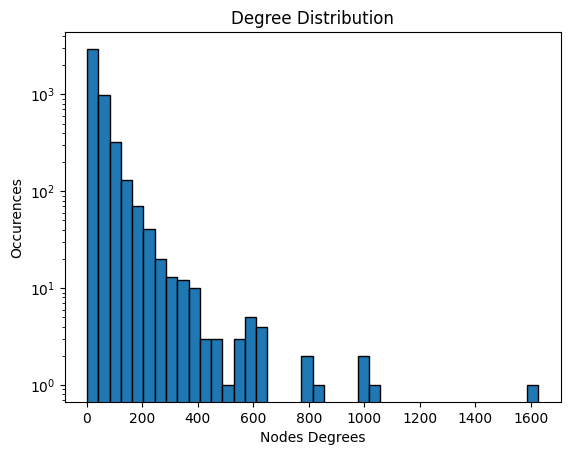

Number of nodes: 4589
Number of edges: 111725
Average degree: 48.69
Network density: 0.0106
Clustering coefficient: 0.2644
Average Shortest path: 2.5124


In [56]:
analyze_graph_statistics(subgraphs_new_edges[0])

### Observations on the New Graph

The new graph has increased connectivity, with new links giving a higher degree. The average shortest path has gone down from 2.5253 to 2.5124, which indicates more efficient navigation. The clustering coefficient has however gone up, which means the new edges contribute less to forming tightly connected clusters.


### Human path analyses

Let's analyze the impact of the new links on the finshed_paths dataset. For each new link generated, we review all paths and verify the presence of the origin node associated with the newly created link. If the origin node is found, we check for the presence of the target node further along the path. If both conditions are met, we remove all nodes visited between the origin and target nodes.

In [32]:
df_to_cut = df_finished
if os.path.exists(os.path.join(cwd, 'results', 'df_cutted_normed.csv')):
    df_cutted_normed = pd.read_csv(os.path.join(cwd, 'results', 'df_cutted_normed.csv'))
else:
    df_cutted = shorten_paths_using_links(df_to_cut, linked_nodes)
    df_cutted_normed = recalculate_num_pages_visited(df_cutted)
df_cutted_normed.head()

,session_id,timestamp,duration,path,rating,num_pages_visited,page_range,path_list,start_page,end_page
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,9,"(5, 10]","['14th_century', '15th_century', '16th_century...",14th_century,African_slave_trade
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,5,"(0, 5]","['14th_century', 'Europe', 'Africa', 'Atlantic...",14th_century,African_slave_trade
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,8,"(5, 10]","['14th_century', 'Niger', 'Nigeria', 'British_...",14th_century,African_slave_trade
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,4,"(0, 5]","['14th_century', 'Renaissance', 'Ancient_Greec...",14th_century,Greece
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,7,"(5, 10]","['14th_century', 'Italy', 'Roman_Catholic_Chur...",14th_century,John_F._Kennedy


To add the duration metrics, we compute the mean time spent on a page in the initial dataset of finished paths, we then multiply this value by the number of pages visited in the new dataset to estimate a new navigation time.

In [33]:
df_for_time = df_finished.copy()
avg = average_time_per_page(df_for_time)
final_cut = redefine_duration(df_cutted_normed, avg)

We can now compare the statistics of the two datasets.

In [34]:
compare_statistics(df_finished, final_cut)

Statistics for Original Dataset:
Mean length of paths: 6.756693557815971
Mean Game duration: 158.27619938423166 seconds
Duration of longest game: 35091 seconds


Statistics for New Dataset:
Mean length of paths: 6.6512139989867105
Mean Game duration: 155.8053305278354 seconds
Duration of longest game: 2248.809274961066 seconds


Differences between Original and New datsets:
Difference in mean length of paths: 0.10547955882926008
Difference in median path length: 0.0
Difference in mean game duration: 2.4708688563962653 seconds
Difference in duration of longest game: 32842.190725038934 seconds


We notice slight differences as a reduction of mean lenght of path and game duration. These results show the efficiency of our model and prove that it can be useful to improve graph connectivity, and that it aids human in their navgation.

In [27]:
compare_statistics_html(df_finished, final_cut)

Comparison statistics have been saved to comparison_statistics.html with a dark background.
